# MNIST Using PyTorch

MNIST problem is like a Hello World of deep learning at this point, and probably everyone who is interested in neural nets goes through it eventually. So, here is my take on it. And I will be using PyTorch to solve it. I haven't yet found a detailed solution of the MNIST with PyTorch on Kaggle, so I figured I'd make my own one.

I will be using fully connected neural net and batched learning algorithm. This model is far from perfect, but I tried to make it as simple as it gets and explain every step of this solution. If you are a beginner and interested in PyTorch, hopefully, this will be helpful to you.

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn as F, optim
import numpy as np
import helper
import matplotlib.pyplot as plt

In [43]:
from torchvision import datasets, transforms
#define a transform to normalize images
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])
#Download and load training data
trainset = datasets.MNIST('MNIST_data/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

#Download and load test set 
testset = datasets.MNIST('MNIST_data/', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False)

Now that data is ready, we can take a look at what we're dealing with.

torch.Size([64, 1, 28, 28])
torch.Size([64])


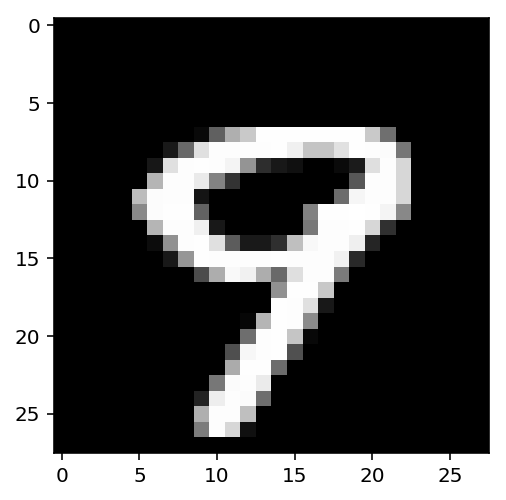

In [111]:
data = iter(trainloader)
images, labels = data.next()
print(images.shape)
print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')

# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a loss function (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$
where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called gradient descent. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='gradient_descent.png' width=350px>

In [54]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
    
        #first input layer
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 64)
        
        #output layer with 10 units
        self.output = nn.Linear(64, 10)
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, x):
        
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x 

Now lets see our network architecture

In [58]:
model = Network()
print(model)

Network(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax()
)


# Autograd 

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, autograd, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set requires_grad = True on a tensor. You can do this at creation with the requires_grad keyword, or at any time with x.requires_grad_(True).

# Backpropagation

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is done through backpropagation which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='backprop_diagram.png' width=550px>

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$
Note: I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$.

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$
The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

# Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the nn module, PyTorch provides losses such as the cross-entropy loss (nn.CrossEntropyLoss). You'll usually see the loss assigned to criterion. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at the documentation for nn.CrossEntropyLoss,

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the logits or scores. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one (read more here). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [75]:
#Define loss 
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

#Get data 
images, labels = next(iter(trainloader))

itr = 1 
epochs = 6
loss_log = []
for e in range(epochs):
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in trainloader:
        itr += 1
        # Flatten images
        images = images.view(images.shape[0], -1)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get outputs
        output = model(images)

        # Calculate loss : Softmax --> NLLLoss
        loss = criterion(output, labels)
        
        # Calculate gradients w.r.t. parameters
        loss.backward()
        
        # Updating parametrs
        optimizer.step()
        
        running_loss += loss.item()
        if itr % 100 == 0:
            loss_log.append(running_loss)
    
    # Calculating accuracy on test images
    for images, labels in testloader:
        #Flatten images
        images = images.view(images.shape[0], -1)
        
        output = model(images)
        _, prediction = torch.max(output, 1)
        
        total += labels.size(0)
        
        correct += (prediction == labels).sum()
    
    accuracy = 100 * correct / total
    
    print('Epoch {} - Training Loss: {:.6f} Accuracy: {:.6f}%'.format(e, running_loss/len(trainloader), accuracy))

Epoch 0 - Training Loss: 0.002019 Accuracy: 98.000000%
Epoch 1 - Training Loss: 0.001127 Accuracy: 98.000000%
Epoch 2 - Training Loss: 0.000918 Accuracy: 98.000000%
Epoch 3 - Training Loss: 0.001623 Accuracy: 98.000000%
Epoch 4 - Training Loss: 0.000877 Accuracy: 98.000000%
Epoch 5 - Training Loss: 0.000593 Accuracy: 98.000000%
Epoch 6 - Training Loss: 0.000706 Accuracy: 98.000000%
Epoch 7 - Training Loss: 0.000551 Accuracy: 98.000000%
Epoch 8 - Training Loss: 0.000387 Accuracy: 98.000000%
Epoch 9 - Training Loss: 0.000353 Accuracy: 98.000000%
Epoch 10 - Training Loss: 0.000324 Accuracy: 98.000000%
Epoch 11 - Training Loss: 0.000326 Accuracy: 98.000000%
Epoch 12 - Training Loss: 0.000291 Accuracy: 98.000000%
Epoch 13 - Training Loss: 0.000285 Accuracy: 98.000000%
Epoch 14 - Training Loss: 0.000313 Accuracy: 98.000000%
Epoch 15 - Training Loss: 0.000266 Accuracy: 98.000000%
Epoch 16 - Training Loss: 0.000243 Accuracy: 98.000000%
Epoch 17 - Training Loss: 0.000231 Accuracy: 98.000000%
Ep

After the network is done with training, we can take a look at the loss function, and how it behaved during training:

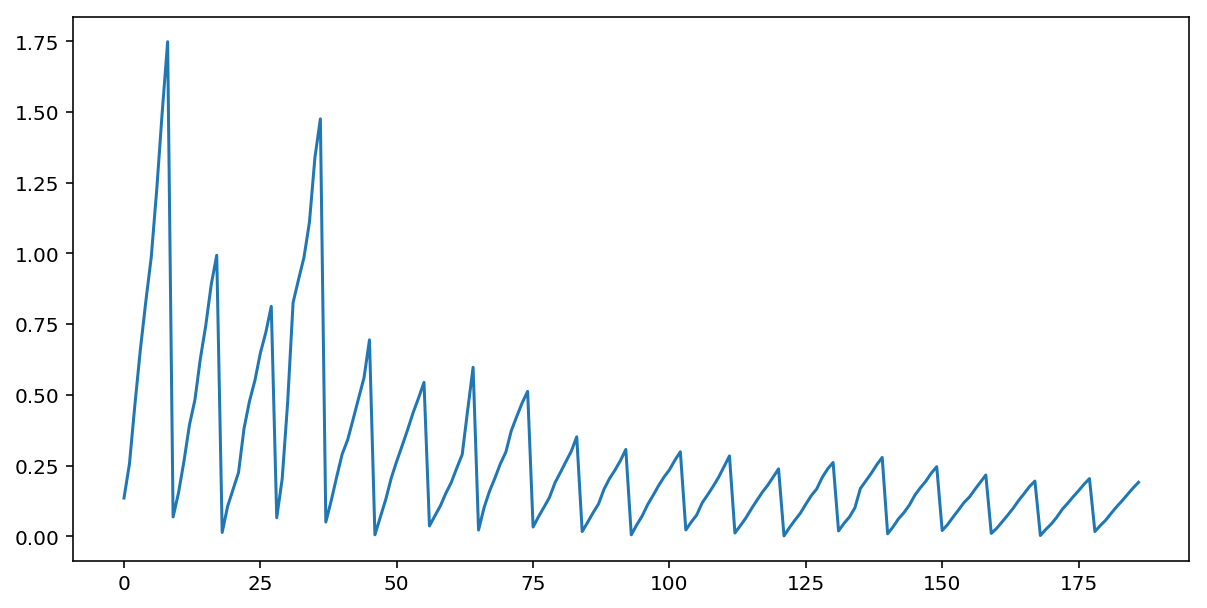

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(loss_log)

Pridicted Value: tensor([2])


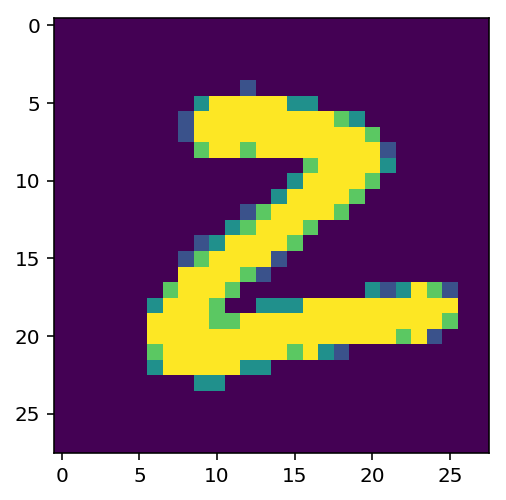

In [123]:
images, labels = next(iter(trainloader))

img = images[0].numpy().squeeze()
plt.imshow(img)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    output = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
_, ps = torch.max(output, 1)
print(f'Pridicted Value:',ps)

And that is about it, we've made a simple neural network using PyTorch that can recognize handwritten digits. Not so bad!

When I was writing this notebook, this model scorred 96.6%, which is not perfect by any means, but it's not that bad either.

I hope this was useful for some of you. If you are totally new to deep learning, I suggest you learn how the neural networks actually work from the inside, especially the backpropagation algorithm.